# ロジスティック回帰に対するハミルトニアンモンテカルロ法

「Juliaで作って学ぶベイズ統計学」P.199 参照

In [1]:
using Distributions
using Plots
using ForwardDiff
using LinearAlgebra

eye(n) = Diagonal{Float64}(I, n)

eye (generic function with 1 method)

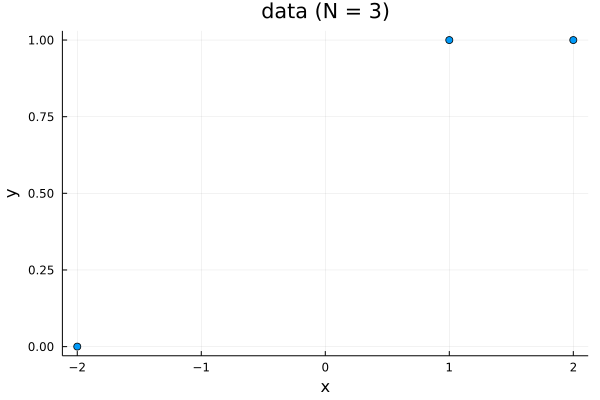

In [2]:
X_obs = [-2, 1, 2]
Y_obs = Bool.([0, 1, 1])
scatter(X_obs, Y_obs, xlab="x", ylab="y",
        label=:none, title="data (N = $(length(X_obs)))")

In [3]:
sig(x) = 1 / (1 + exp(-x))

σ = 1.0
μ₁ = 0.0
μ₂ = 0.0
σ₁ = 10.0
σ₂ = 10.0;

In [4]:
log_joint(w, X, Y, μ₁, σ₁, μ₂, σ₂) =
    logpdf(Normal(μ₁, σ₁), w[1]) +
    logpdf(Normal(μ₂, σ₂), w[2]) +
    sum(logpdf.(Bernoulli.(sig.(w[1] * X .+ w[2])), Y))
ulp(w) = log_joint(w, params...)

ulp (generic function with 1 method)

In [5]:
params = (X_obs, Y_obs, μ₁, σ₁, μ₂, σ₂)
w_init = randn(2)

2-element Vector{Float64}:
  0.15334003370843213
 -1.9450966336850704

In [6]:
function hmc(log_p_tilde, μ₀, maxiter, L, ϵ)
    function leapflog(grad, p_in, μ_in, L, ϵ)
        μ = μ_in
        p = p_in + 0.5 * ϵ * grad(μ)
        for l in 1:L-1
            μ += ϵ * p
            p += ϵ * grad(μ)
        end
        μ += ϵ * p
        p += 0.5 * ϵ * grad(μ)
        p, μ
    end
    grad(μ) = ForwardDiff.gradient(log_p_tilde, μ)
    D = length(μ₀)
    μ_samples = Array{typeof(μ₀[1]), 2}(undef, D, maxiter)
    μ_samples[:, 1] = μ₀
    num_accepted = 1
    for i in 2:maxiter
        p_in = randn(size(μ₀))
        p_out, μ_out = leapflog(grad, p_in, μ_samples[:, i-1], L, ϵ)
        μ_in = μ_samples[:, i-1]
        log_r = (log_p_tilde(μ_out) +
                logpdf(MvNormal(zeros(D), eye(D)), vec(p_out))) -
                (log_p_tilde(μ_in) +
                logpdf(MvNormal(zeros(D), eye(D)), vec(p_in)))
        is_accepted = min(1, exp(log_r)) > rand()
        new_sample = is_accepted ? μ_out : μ_in
        μ_samples[:, i] = new_sample
        num_accepted += is_accepted
    end
    μ_samples, num_accepted
end

function inference_wrapper_hmc(log_joint, params, w_init, maxiter, L, ϵ)
    ulp(w) = log_joint(w, params...)
    hmc(ulp, w_init, maxiter, L, ϵ)
end


inference_wrapper_hmc (generic function with 1 method)

In [7]:
maxiter = 300
L = 10
ϵ = 1e-0

μ_samples, num_accepted = inference_wrapper_hmc(log_joint, params, w_init, maxiter, L, ϵ)

([0.15334003370843213 21.321874410774978 … 11.1957835263041 11.144044446769708; -1.9450966336850704 5.498223780807239 … 2.808818288040771 5.985736941940026], 288)

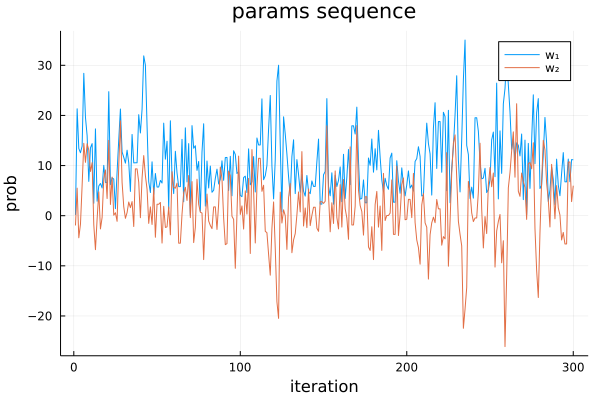

In [8]:
plot(μ_samples[1, :], xlab="iteration", ylab="prob", title="params sequence", label="w₁")
plot!(μ_samples[2, :], xlab="iteration", ylab="prob", title="params sequence", label="w₂")

In [9]:
w₁s = range(-10, 30, length=100)
w₂s = range(-20, 20, length=100);

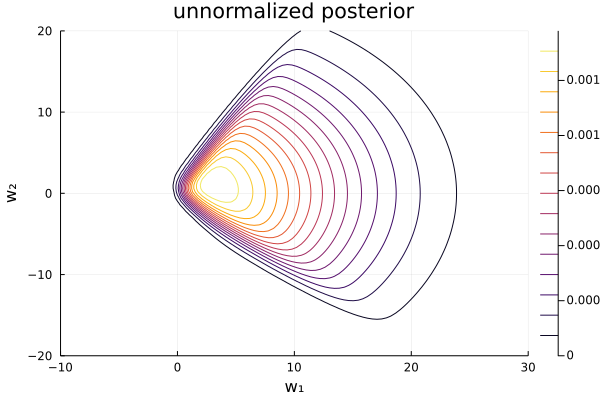

In [10]:
contour(w₁s, w₂s, [exp(ulp([w₁, w₂])) for w₁ in w₁s, w₂ in w₂s]',
        xlab="w₁", ylab="w₂", title="unnormalized posterior")

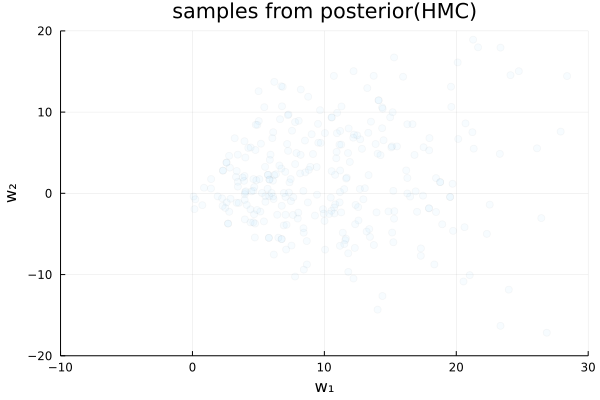

In [11]:
scatter(μ_samples[1, :], μ_samples[2, :], alpha=10/maxiter,
        xlim=(-10,30), ylim=(-20,20), xlab="w₁", ylab="w₂", title="samples from posterior(HMC)", label=:none)

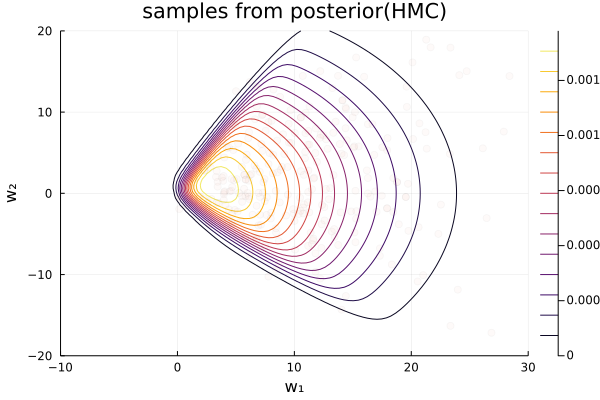

In [12]:
contour(w₁s, w₂s, [exp(ulp([w₁, w₂])) for w₁ in w₁s, w₂ in w₂s]', xlab="w₁", ylab="w₂")
scatter!(μ_samples[1, :], μ_samples[2, :], alpha=10/maxiter,
        xlim=(-10,30), ylim=(-20,20), xlab="w₁", ylab="w₂", title="samples from posterior(HMC)", label=:none)

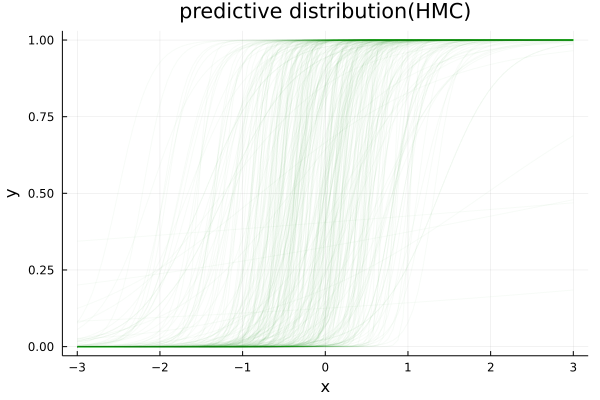

In [13]:
xs = range(-3, 3, length=100)
p = plot(xlab="x", ylab="y", title="predictive distribution(HMC)")
fs = []
for i in 1:size(μ_samples, 2)
    w₁, w₂ = μ_samples[:, i]
    f(x) = sig(w₁ * x + w₂)
    push!(fs, f.(xs))
    p = plot!(xs, f.(xs), linecolor=:green, alpha=10/maxiter, label=:none)
end
p

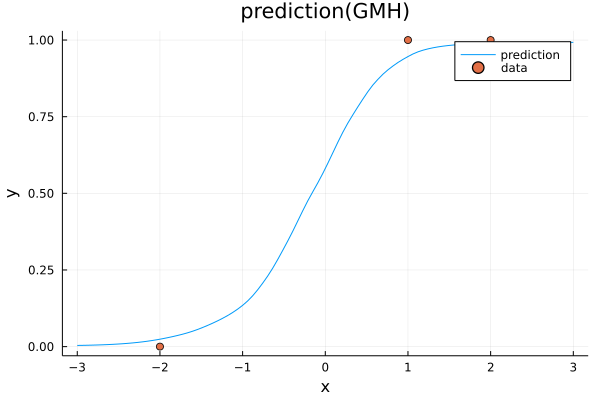

In [14]:
plot(xs, mean(fs), xlab="x", ylab="y", title="prediction(GMH)", label="prediction")
scatter!(X_obs, Y_obs, label="data")